# Faostat global model
In this notebook we create an ensemble of multilayer perceptron ([MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) models to fit the world crop yields using the input variables: precipitation, air temperature, natural and synthetic fertilizers.

In [16]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## The dataset
We load the dataset that was prepared by putting into the same file the predictors and the predictands data

In [17]:
global_crop_yield_path = 'data/global_dataset.csv'
global_crop_yield_df = pd.read_csv(global_crop_yield_path, index_col=0)
global_crop_yield_df.head(2)

,Maize (100g/ha),Millet (100g/ha),Temp. Anom. (°C),Prec.Anom. (mm),CO2 (ppm),Manure (Mt),Nitrogen (tons),Phosphate (tons),Potash (tons)
1961-12-31,19423,5925,0.211,15.318908,317.64,1.835092e+10,11486265.27,10888968.81,8626724.57
1962-12-31,19796,5619,0.038,0.768900,318.45,1.872918e+10,12969831.11,11534554.43,9146891.38


## Data preparation
Since the values for the variables differ by orders of magnitude, we normalize them before using the data as input for the model. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from the scikit-learn package to normalize the values. The scaler removes the mean and scale the values to unit variance. We start by selecting the columns with the input data

In [18]:
X = global_crop_yield_df.iloc[:, [2, 3, 4, 5, 6]].to_numpy()
y = global_crop_yield_df.iloc[:, [0]].to_numpy()

and the column of the predictand (maize)

In [19]:
y[:1]

array([[19423]], dtype=int64)

In [20]:
from sklearn import preprocessing
scaler_x = preprocessing.StandardScaler().fit(X)

The scaler computes the mean of the input variables

In [21]:
mean_x = scaler_x.mean_[0]
mean_x

0.5707741935483871

and the variance

In [22]:
variance_x = scaler_x.scale_[0]
variance_x

0.5387043721971724

we use the scaler to normalize the input variables

In [23]:
X_scaled = scaler_x.transform(X)
X_scaled.shape

(62, 5)

In [24]:
scaler_y = preprocessing.StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)
y_scaled.shape

(62, 1)

In [25]:
mean_y = scaler_y.mean_[0]
mean_y

38951.403225806454

In [26]:
variance_y = scaler_y.scale_[0]
variance_y

11966.558404448891

## Train and test set
The data used to train a model of the ensemble is divided into a train set and a test set

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55, 5), (55, 1), (7, 5), (7, 1))

## Ensemble models training

In [28]:
num_observations = X.shape[0]
num_observations

62

We train an ensemble of MLP models that start with a different init parameters

In [29]:
import random 
num_ensemble_members = 20 
from random import randint
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

A random state is the seed used during the training of a model of the ensemble

In [30]:
random_states[:]

[37, 13, 62, 38, 22, 43, 29, 24, 7, 31, 25, 47, 54, 42, 31, 22, 20, 42, 6, 51]

We initialize a 2D array that will contain the predictions of the ensemble models

In [31]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(62, 20)

In [32]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(5, ),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs'
            )
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X_scaled)
    ensemble_members[:, i] = model_sample
    print('Ensemble {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}\n")

Ensemble 0
done in 0.233s
Train R2 score: 0.99
Test R2 score: 0.85

Ensemble 1
done in 0.068s
Train R2 score: 0.99
Test R2 score: 0.98

Ensemble 2
done in 0.060s
Train R2 score: 0.99
Test R2 score: 0.97

Ensemble 3
done in 0.059s
Train R2 score: 0.99
Test R2 score: 1.00

Ensemble 4
done in 0.065s
Train R2 score: 0.99
Test R2 score: 0.92

Ensemble 5
done in 0.067s
Train R2 score: 0.99
Test R2 score: 0.91

Ensemble 6
done in 0.060s
Train R2 score: 0.99
Test R2 score: 0.94

Ensemble 7
done in 0.060s
Train R2 score: 0.99
Test R2 score: 0.98

Ensemble 8
done in 0.066s
Train R2 score: 0.99
Test R2 score: 0.90

Ensemble 9
done in 0.069s
Train R2 score: 0.99
Test R2 score: 0.94

Ensemble 10
done in 0.061s
Train R2 score: 0.99
Test R2 score: 0.97

Ensemble 11
done in 0.057s
Train R2 score: 0.99
Test R2 score: 0.91

Ensemble 12
done in 0.067s
Train R2 score: 1.00
Test R2 score: 0.85

Ensemble 13
done in 0.081s
Train R2 score: 0.99
Test R2 score: 0.99

Ensemble 14
done in 0.058s
Train R2 score: 0

In [33]:
len(ensemble_members[:,0])

62

## Inverse transform
We denormalize the predictions by inverting the predicted values. We can perform the inverse transform using a simple equation

In [34]:
ensemble_denorm = ensemble_members * variance_y + mean_y
ensemble_denorm[:,0]

array([18826.58048269, 20004.02698039, 19968.59910859, 19975.30422254,
       21410.10590859, 21736.7503782 , 23707.91333919, 24142.64503549,
       24549.45966503, 24518.70280409, 26472.75320471, 27176.33464658,
       27576.33578002, 25689.49601202, 28119.79253721, 27645.41726947,
       30728.2251246 , 30958.69969941, 31363.08385578, 31371.93848185,
       33680.76339313, 35544.85643485, 30391.42943754, 35700.27820067,
       36755.81313485, 36414.5680637 , 34390.83345945, 36008.73567694,
       37129.00177324, 34049.73190098, 36613.56385217, 39631.01109141,
       42041.12791454, 40568.2820398 , 38756.69323439, 41678.27416918,
       40760.66103675, 43479.70174738, 43787.7975757 , 44327.40028433,
       45332.68627   , 43674.47136591, 46218.79304435, 47356.8493997 ,
       47631.51135805, 48943.25067811, 49373.2183111 , 50526.54053353,
       50858.94371469, 51405.21582423, 51892.31329844, 52564.81445277,
       53226.89871428, 54218.74493446, 56332.42722954, 57053.194445  ,
      

or we can use the function provided by the scaler

In [35]:
prediction = scaler_y.inverse_transform(ensemble_members)
prediction[:, 0]

array([18826.58048269, 20004.02698039, 19968.59910859, 19975.30422254,
       21410.10590859, 21736.7503782 , 23707.91333919, 24142.64503549,
       24549.45966503, 24518.70280409, 26472.75320471, 27176.33464658,
       27576.33578002, 25689.49601202, 28119.79253721, 27645.41726947,
       30728.2251246 , 30958.69969941, 31363.08385578, 31371.93848185,
       33680.76339313, 35544.85643485, 30391.42943754, 35700.27820067,
       36755.81313485, 36414.5680637 , 34390.83345945, 36008.73567694,
       37129.00177324, 34049.73190098, 36613.56385217, 39631.01109141,
       42041.12791454, 40568.2820398 , 38756.69323439, 41678.27416918,
       40760.66103675, 43479.70174738, 43787.7975757 , 44327.40028433,
       45332.68627   , 43674.47136591, 46218.79304435, 47356.8493997 ,
       47631.51135805, 48943.25067811, 49373.2183111 , 50526.54053353,
       50858.94371469, 51405.21582423, 51892.31329844, 52564.81445277,
       53226.89871428, 54218.74493446, 56332.42722954, 57053.194445  ,
      

In [38]:
diff = prediction[:, 0] - ensemble_denorm[:,0] == 0
diff.all()

True

We compute the ensemble values

In [43]:
ensemble = prediction.sum(axis=1) / num_ensemble_members
ensemble

array([19825.96159942, 20020.37576734, 20458.45110567, 20425.74338209,
       22052.46256629, 21917.28497932, 23069.77588769, 23344.78228417,
       23809.30863914, 24292.77770113, 25656.90774721, 27076.3968569 ,
       27123.16555706, 25668.32551781, 28432.04560424, 29246.81836764,
       30943.30017836, 31357.0360812 , 32936.05244343, 31943.12810332,
       33198.94922995, 35325.2692606 , 30977.41221976, 35616.94849312,
       36880.08698717, 35542.09159924, 34713.94900681, 32140.52027218,
       36148.90660752, 36140.78988337, 37441.27045925, 39024.61758116,
       39040.78318761, 39417.7842707 , 38543.76496303, 41423.6690902 ,
       40991.58199033, 43486.68959244, 44058.38382506, 44193.94684874,
       44971.92936071, 44235.62963722, 45811.93975523, 47309.0907438 ,
       47562.01026053, 48985.91740787, 49909.57872256, 50317.7604395 ,
       50717.90818189, 51587.02309937, 51768.08489843, 52417.33506724,
       53379.60164672, 54109.57831074, 55112.20439481, 57368.68135319,
      

## Best ensemble model visualization
We use the ensemble 16 with the best test R2 score

In [44]:
best_model_predictions = prediction[:,4]

In [45]:
#model_sample_best = predictions_denorm.iloc[:, 16]
#model_sample_best[:2]

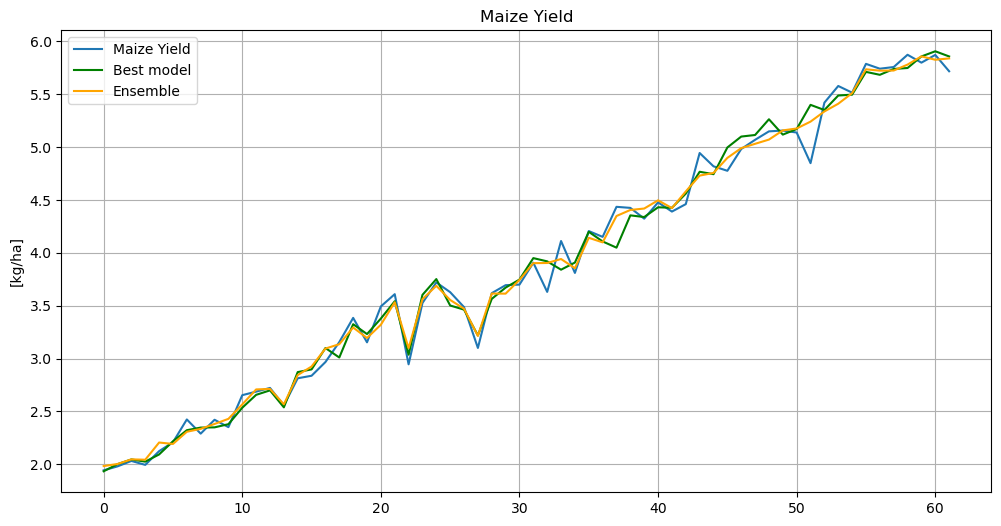

In [49]:
from matplotlib import dates
import matplotlib.dates as mdates

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
ax.set_ylabel('[kg/ha]');
ax.grid(True, which='both')
#ax.set_xticks(predictions_denorm.index)
#ax.set_xticklabels(predictions_denorm.index, rotation=70)
#ax.xaxis.set_major_locator(dates.YearLocator(5))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#maize_yield = global_crop_yield_df['Maize (100g/ha)'] / 10000 
pd_maize_yield, = plt.plot(y / 10000, label='Maize Yield')
pd_predictions_best, = plt.plot(best_model_predictions / 10000, label='Best model', color='green')
pd_ensemble, = plt.plot(ensemble / 10000, label='Ensemble', color='orange')
plt.legend(handles=[pd_maize_yield, pd_predictions_best, pd_ensemble], loc='upper left')